In [1]:
import pandas as pd 

data = pd.read_csv('data_no_bg.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data.head()

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab


In [2]:
len(data.nom_maladie.unique())

21

### Création d'un échantillon 

In [3]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_79048\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_79048\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_79048\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_79048\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_79048\3821067970

In [4]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Grape,True,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,True,Early_blight
2,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Strawberry,True,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Soybean,False,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,False,healthy
4985,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Apple,True,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Potato,True,Late_blight
4987,C:\Users\aissa\Desktop\Projet\dataset_remove_b...,Tomato,True,Tomato_Yellow_Leaf_Curl_Virus


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [6]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.nom_maladie.unique())

### Prétraitement des données

In [7]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [8]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="nom_maladie",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 3992 validated image filenames belonging to 21 classes.


In [9]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="nom_maladie",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 997 validated image filenames belonging to 21 classes.


### Modélisation sur l'échantillon

In [10]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
# Compilation du modèle

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 182s 3s/step - loss: 3.0959 - accuracy: 0.3562 - val_loss: 2.4202 - val_accuracy: 0.4000
Epoch 2/8
62/62 [==============================] - 193s 3s/step - loss: 2.0932 - accuracy: 0.4840 - val_loss: 1.9605 - val_accuracy: 0.5208
Epoch 3/8
62/62 [==============================] - 191s 3s/step - loss: 1.7160 - accuracy: 0.5675 - val_loss: 1.6559 - val_accuracy: 0.6115
Epoch 4/8
62/62 [==============================] - 182s 3s/step - loss: 1.4822 - accuracy: 0.6298 - val_loss: 1.6383 - val_accuracy: 0.5990
Epoch 5/8
62/62 [==============================] - 186s 3s/step - loss: 1.2945 - accuracy: 0.6940 - val_loss: 1.6294 - val_accuracy: 0.5990
Epoch 6/8
62/62 [==============================] - 173s 3s/step - loss: 1.1713 - accuracy: 0.7391 - val_loss: 1.7275 - val_accuracy: 0.5792
Epoch 7/8
62/62 [==============================] - 172s 3s/step - loss: 1.0858 - accuracy: 0.7762 - val_loss: 1.6221 - val_accuracy: 0.6375
Epoch 8/8
62/62 [===

### Généralisation à l'ensemble du dataset

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

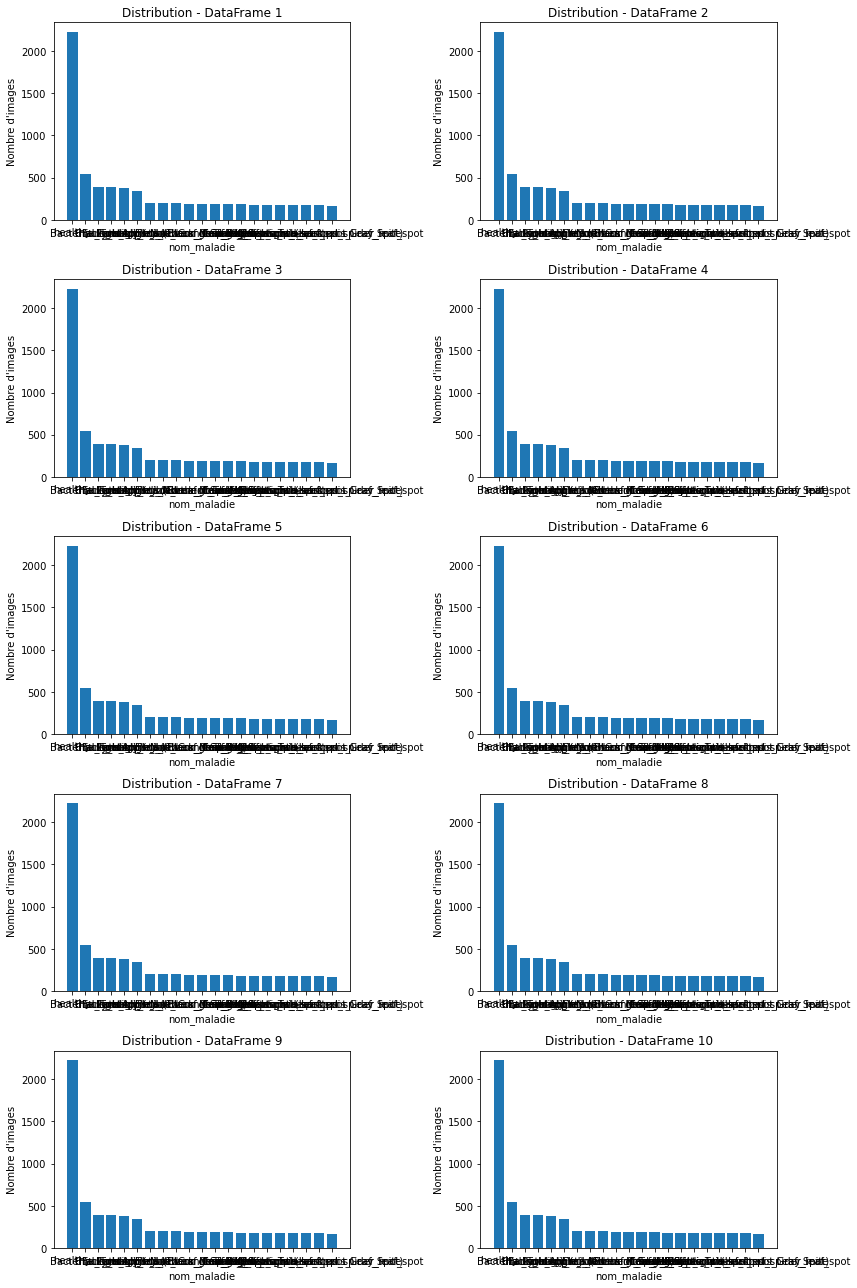

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt 

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['nom_maladie']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)

for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['nom_maladie'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("nom_maladie")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [15]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="nom_maladie",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 5624 validated image filenames belonging to 21 classes.
Found 1405 validated image filenames belonging to 21 classes.
Found 56

### Modélisation 

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_nom_maladie_no_bg.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.9789 - accuracy: 0.3336
Epoch 1: val_loss improved from inf to 2.27347, saving model to cnn_id_nom_maladie_no_bg.h5
87/87 [==============================] - 249s 3s/step - loss: 2.9789 - accuracy: 0.3336 - val_loss: 2.2735 - val_accuracy: 0.3817
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 2.0590 - accuracy: 0.4585
Epoch 2: val_loss improved from 2.27347 to 1.95717, saving model to cnn_id_nom_maladie_no_bg.h5
87/87 [==============================] - 244s 3s/step - loss: 2.0590 - accuracy: 0.4585 - val_loss: 1.9572 - val_accuracy: 0.4821
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.7496 - accuracy: 0.5309
Epoch 3: val_loss improved from 1.95717 to 1.74106, saving model to cnn_id_nom_maladie_no_bg.h5
87/87 [==============================] - 243s 3s/step - loss: 1.7496 - accuracy: 0.5309 - val_loss: 1.7411 - val_accuracy: 0.5484
Epoch 4/8


Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.6252 - accuracy: 0.9295
Epoch 5: val_loss did not improve from 1.19062
87/87 [==============================] - 247s 3s/step - loss: 0.6252 - accuracy: 0.9295 - val_loss: 1.3177 - val_accuracy: 0.7448
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.9415
Epoch 6: val_loss did not improve from 1.19062
87/87 [==============================] - 247s 3s/step - loss: 0.6047 - accuracy: 0.9415 - val_loss: 1.3579 - val_accuracy: 0.7374
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.9576
Epoch 7: val_loss did not improve from 1.19062
87/87 [==============================] - 250s 3s/step - loss: 0.5368 - accuracy: 0.9576 - val_loss: 1.3699 - val_accuracy: 0.7522
Epoch 8/8
87/87 [==============================] - ETA: 0s - loss: 0.5042 - accuracy: 0.9656
Epoch 8: val_loss did not improve from 1.19062
87/87 [==============================] - 246s 3s/s

87/87 [==============================] - 246s 3s/step - loss: 1.2024 - accuracy: 0.7478 - val_loss: 1.0608 - val_accuracy: 0.7984
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.9189
Epoch 2: val_loss did not improve from 0.97629
87/87 [==============================] - 245s 3s/step - loss: 0.6824 - accuracy: 0.9189 - val_loss: 1.0594 - val_accuracy: 0.8043
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 0.5268 - accuracy: 0.9644
Epoch 3: val_loss did not improve from 0.97629
87/87 [==============================] - 245s 3s/step - loss: 0.5268 - accuracy: 0.9644 - val_loss: 1.0015 - val_accuracy: 0.8237
Epoch 4/8
87/87 [==============================] - ETA: 0s - loss: 0.4316 - accuracy: 0.9820
Epoch 4: val_loss improved from 0.97629 to 0.96799, saving model to cnn_id_nom_maladie_no_bg.h5
87/87 [==============================] - 247s 3s/step - loss: 0.4316 - accuracy: 0.9820 - val_loss: 0.9680 - val_accuracy: 0.8162
Epoch 5/8
8

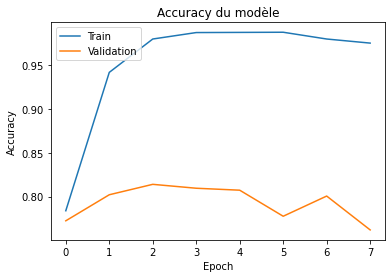

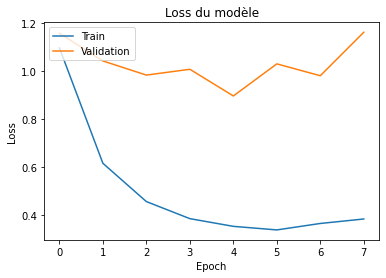

In [17]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Sauvegarde du modèle

In [21]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.load_weights('cnn_id_nom_maladie_no_bg.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_nom_maladie_no_bg.h5')